[Why Python is Slow](http://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/) by Jake VanderPlas. 

In [1]:
import sys
print("Python version =", sys.version[:5])

Python version = 3.9.1


# Integers

Integers in Python are usually an integer object like: 
```
struct _longobject {
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
    long ob_digit[1];
};

```

In [2]:
import ctypes

class IntStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong),
                ("ob_digit", ctypes.c_long)]
    
    def __repr__(self):
        return ("IntStruct(ob_digit={self.ob_digit}, "
                "refcount={self.ob_refcnt})").format(self=self)

In [3]:
num = 42 
IntStruct.from_address(id(42))

IntStruct(ob_digit=42, refcount=35)

`ob_digit` has the correct value, but why is `refcount` 35? Python uses small integers a lot, so only copy of many commonly used integers is stored in memory. 

In [4]:
x = 42
y = 42 
assert id(x) == id(y)

Starting up the Python interpreter itself creates lots of integers. Here're the number of references to each:

Text(0, 0.5, 'reference count')

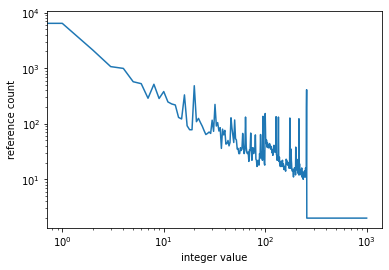

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import sys
plt.loglog(range(1000), [sys.getrefcount(i) for i in range(1000)])
plt.xlabel('integer value')
plt.ylabel('reference count')

In [6]:
# Just double-checking that ob_digit is correct for all 
all(i == IntStruct.from_address(id(i)).ob_digit
    for i in range(10**3))

False

In [7]:
all(i == IntStruct.from_address(id(i)).ob_digit
    for i in range(256))

True

Why isn't `ob_digit` the expected value for higher integers? Python does some bit shifting magic for larger values so that it can easily handle integers past the overflow limit of the `long` data type. 

# Lists

Lists in Python are defined as: 
```
typedef struct {
    long ob_refcnt;
    PyTypeObject *ob_type;
    Py_ssize_t ob_size;
    PyObject **ob_item;
    long allocated;
} PyListObject;
```

In [8]:
class ListStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong),
                ("ob_item", ctypes.c_long),  # PyObject** pointer cast to long
                ("allocated", ctypes.c_ulong)]
    
    def __repr__(self):
        return ("ListStruct(len={self.ob_size}, "
                "refcount={self.ob_refcnt})").format(self=self)

In [9]:
L = [1,2,3,4,5]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=1)

In [10]:
# refcount should be 3
tup = [L, L]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=3)

In [11]:
Lstruct = ListStruct.from_address(id(L))
PtrArray = Lstruct.ob_size * ctypes.POINTER(IntStruct)
L_values = PtrArray.from_address(Lstruct.ob_item)
[ptr[0] for ptr in L_values] # ptr[0] dereferences

[IntStruct(ob_digit=1, refcount=8371),
 IntStruct(ob_digit=2, refcount=3602),
 IntStruct(ob_digit=3, refcount=1354),
 IntStruct(ob_digit=4, refcount=1056),
 IntStruct(ob_digit=5, refcount=1061)]

# NumPy arrays

In [12]:
import numpy as np 
np.__version__

'1.20.2'

In [13]:
class NumpyStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_data", ctypes.c_long),  # char* pointer cast to long
                ("ob_ndim", ctypes.c_int),
                ("ob_shape", ctypes.c_voidp),
                ("ob_strides", ctypes.c_voidp)]
    
    @property
    def shape(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_shape))
    
    @property
    def strides(self):
        return tuple((self.ob_ndim * ctypes.c_int64).from_address(self.ob_strides))
    
    def __repr__(self):
        return ("NumpyStruct(shape={self.shape}, "
                "refcount={self.ob_refcnt})").format(self=self)

In [14]:
x = np.random.random((10, 20))
xstruct = NumpyStruct.from_address(id(x))
xstruct

NumpyStruct(shape=(10, 20), refcount=1)

In [15]:
L = [x, x, x]
xstruct # refcount should be 4

NumpyStruct(shape=(10, 20), refcount=4)

Here we assume this is a CONTINUOUS array, unlike the pointer dereferencing we did for Python lists. Notice it works.

In [16]:
x = np.arange(10)
xstruct = NumpyStruct.from_address(id(x))
size = np.prod(xstruct.shape)

# assume an array of integers
arraytype = size * ctypes.c_long
data = arraytype.from_address(xstruct.ob_data)

[d for d in data]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [17]:
x[4] = 555
[d for d in data]

[0, 1, 2, 3, 555, 5, 6, 7, 8, 9]

# Changing values of integers

In [18]:
# WARNNG: never do this!
id113 = id(113)
iptr = IntStruct.from_address(id113)
iptr.ob_digit = 4  # now Python's 113 contains a 4!

113 == 4

True

In [19]:
113

4

In [20]:
112 + 1

4

In [21]:
iptr.ob_digit = 113

In [22]:
113

4

Notice that we can't simply change it back to 113 because *113 no longer exists*. Instead, we manipulate the bits directly: 113 = 8 * 16 + 1 * 0, so on a little-endian 64-bit system: 

In [23]:
ctypes.cast(id113, ctypes.POINTER(ctypes.c_char))[3 * 8] = b'\x71'
113

113